<a href="https://colab.research.google.com/github/rjrizani/Machine-learning-tf/blob/master/intro_to_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pengantar Jaringan Neural

**Tujuan Pembelajaran:**
  * Menentukan jaringan neural (JN) dan lapisannya yang tersembunyi menggunakan kelas `DNNRegressor` TensorFlow
  * Melatih jaringan neural untuk mempelajari nonlinearitas dalam kumpulan data dan mencapai performa yang lebih baik dibandingkan model regresi linear

Dalam latihan sebelumnya, kita menggunakan fitur sintetis untuk membantu model menggabungkan nonlinearitas.

Satu set nonlinearitas yang penting terdiri dari garis lintang dan garis bujur, tetapi mungkin saja ada yang lain.

Untuk saat ini, kita juga akan beralih kembali ke tugas regresi standar, dan bukan tugas regresi logistik dari latihan sebelumnya. Dengan demikian, kita akan langsung memprediksi `median_house_value`.

## Penyiapan

Pertama, mari muat dan siapkan data.

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

TensorFlow 1.x selected.


In [3]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2653.6,540.3,1431.6,501.9,3.9,2.0
std,2.1,2.0,12.6,2216.7,426.6,1179.4,388.4,1.9,1.3
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1461.0,296.0,788.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2131.0,435.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3147.2,645.0,1711.0,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2619.8,537.2,1424.7,499.6,3.9,2.0
std,2.1,2.0,12.6,2089.2,408.9,1068.3,375.0,1.9,0.9
min,32.6,-124.3,1.0,18.0,4.0,8.0,3.0,0.5,0.0
25%,33.9,-121.7,18.0,1465.2,298.0,792.8,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2118.0,433.0,1177.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3160.2,658.0,1749.0,609.2,4.8,2.3
max,41.9,-114.6,52.0,30405.0,4952.0,12873.0,4616.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,207.9
std,115.6
min,15.0
25%,120.7
50%,181.6
75%,265.2
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.0
std,116.9
min,17.5
25%,117.6
50%,176.3
75%,263.9
max,500.0


## Membuat Jaringan Neural

JN ditentukan berdasarkan kelas [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor).

Gunakan **`hidden_units`** untuk menentukan struktur JN. Argumen `hidden_units` memberikan daftar int, di mana setiap int sesuai dengan lapisan tersembunyi dan menunjukkan jumlah simpul di dalamnya. Misalnya, pertimbangkan penetapan berikut:

`hidden_units=[3,10]`

Penetapan sebelumnya menentukan jaringan neural dengan dua lapisan tersembunyi:

* Lapisan tersembunyi yang pertama berisi 3 simpul.
* Lapisan tersembunyi yang kedua berisi 10 simpul.

Jika ingin menambahkan lapisan lainnya, kita akan menambahkan lebih banyak int ke daftar. Misalnya, `hidden_units=[10,20,30,40]` akan menghasilkan empat lapisan dan tiap-tiap lapisan memiliki nilai sepuluh, dua puluh, tiga puluh, dan empat puluh unit.

Secara default, semua lapisan tersembunyi akan menggunakan aktivasi ULT dan akan terhubung sepenuhnya.

In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## Tugas 1: Melatih Model JN

**Sesuaikan hyperparameter, dengan tujuan menurunkan nilai GARK di bawah 110.**

Jalankan blok berikut untuk melatih model JN.

Perlu diingat bahwa dalam latihan regresi linear yang menggunakan banyak fitur, nilai GARK sekitar 110 sudah cukup bagus. Tujuan kita adalah mengalahkan nilai tersebut.

Tugas Anda di sini adalah untuk memodifikasi berbagai setelan pembelajaran guna meningkatkan akurasi pada data validasi.

Overfitting merupakan potensi bahaya yang nyata bagi JN. Anda dapat melihat kesenjangan antara kerugian pada data pelatihan dan kerugian pada data validasi guna membantu menilai apakah model Anda mulai melakukan overfitting. Jika kesenjangan mulai melebar, hal tersebut biasanya merupakan tanda nyata dari overfitting.

Karena banyaknya kemungkinan setelan yang berbeda, sangat disarankan untuk membuat catatan pada setiap uji coba untuk membantu memandu proses pengembangan Anda.

Selain itu, saat Anda memiliki setelan yang baik, coba jalankan setelan tersebut beberapa kali dan lihat seberapa berulang hasil Anda. Bobot JN biasanya dimulai dari nilai acak yang kecil, sehingga Anda akan melihat perbedaan di setiap sesi yang dijalankan.


Training model...
RMSE (on training data):
  period 00 : 237.66
  period 01 : 167.39
  period 02 : 172.93
  period 03 : 169.10
  period 04 : 180.51
  period 05 : 162.26
  period 06 : 157.55
  period 07 : 146.85
  period 08 : 153.27
  period 09 : 138.08
Model training finished.
Final RMSE (on training data):   138.08
Final RMSE (on validation data): 136.58


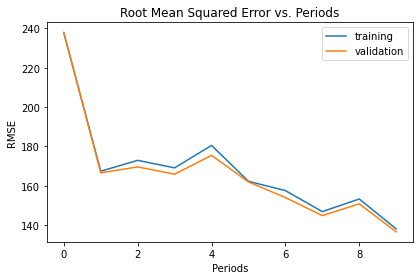

In [10]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah untuk melihat solusi yang memungkinkan

**CATATAN:** Pemilihan parameter ini bersifat cukup arbitrer. Di sini kita telah mencoba kombinasi yang semakin kompleks, yang digabungkan dengan pelatihan yang durasinya lebih lama, hingga rasio error turun di bawah objektif. Ini mungkin bukan kombinasi terbaik; kombinasi lainnya mungkin mencapai GARK yang lebih rendah. Jika tujuan Anda adalah menemukan model yang dapat mencapai error terbaik, sebaiknya Anda menggunakan proses yang lebih ketat, seperti penelusuran parameter.

Training model...
RMSE (on training data):
  period 00 : 157.45
  period 01 : 146.17
  period 02 : 132.06
  period 03 : 118.04
  period 04 : 110.77
  period 05 : 102.83
  period 06 : 101.38
  period 07 : 101.11
  period 08 : 101.29
  period 09 : 99.83
Model training finished.
Final RMSE (on training data):   99.83
Final RMSE (on validation data): 100.42


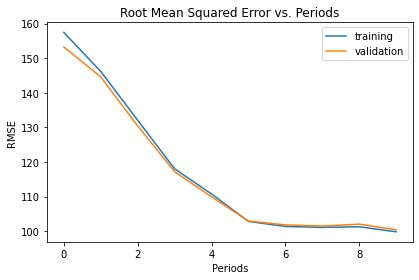

In [11]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Tugas 2: Mengevaluasi Data Pengujian

**Konfirmasikan bahwa hasil performa validasi Anda dapat bertahan terhadap data pengujian.**

Setelah Anda mendapatkan model yang Anda inginkan, lakukan evaluasi model pada data pengujian untuk membandingkannya dengan performa validasi.

Sekadar mengingatkan, kumpulan data pengujian tersedia [di sini](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [ ]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE

### Solusi

Klik di bawah untuk melihat solusi yang memungkinkan.

Seperti yang dilakukan oleh kode di atas, kita hanya perlu memuat file data yang sesuai, memproses file tersebut sebelumnya, serta memanggil prediksi dan mean_squared_error.

Perhatikan bahwa kita tidak harus mengacak data pengujian, karena kita akan menggunakan semua catatan.

In [12]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 99.33
